<a href="https://colab.research.google.com/github/tbradshaw91/DS-Unit-2-Sprint-4-Practicing-Understanding/blob/master/DS_Unit_2_Sprint_Challenge_4_Practicing_Understanding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

_Lambda School Data Science Unit 2_
 
 # Sprint Challenge: Practicing & Understanding Predictive Modeling

### Chicago Food Inspections

For this Sprint Challenge, you'll use a dataset with information from inspections of restaurants and other food establishments in Chicago from January 2010 to March 2019. 

[See this PDF](https://data.cityofchicago.org/api/assets/BAD5301B-681A-4202-9D25-51B2CAE672FF) for descriptions of the data elements included in this dataset.

According to [Chicago Department of Public Health — Food Protection Services](https://www.chicago.gov/city/en/depts/cdph/provdrs/healthy_restaurants/svcs/food-protection-services.html), "Chicago is home to 16,000 food establishments like restaurants, grocery stores, bakeries, wholesalers, lunchrooms, mobile food vendors and more. Our business is food safety and sanitation with one goal, to prevent the spread of food-borne disease. We do this by inspecting food businesses, responding to complaints and food recalls." 

#### Your challenge: Predict whether inspections failed

The target is the `Fail` column.

- When the food establishment failed the inspection, the target is `1`.
- When the establishment passed, the target is `0`.

## **Libraries**

**Installs**

In [0]:
!pip install category-encoders
!pip install eli5
!pip install shap

**Imports**

In [0]:
import category_encoders as ce
import pandas as pd
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from scipy.stats import randint
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

#### Run this cell to load the data:

In [0]:
train_url = 'https://drive.google.com/uc?export=download&id=13_tP9JpLcZHSPVpWcua4t2rY44K_s4H5'
test_url  = 'https://drive.google.com/uc?export=download&id=1GkDHjsiGrzOXoF_xcYjdzBTSjOIi3g5a'

train = pd.read_csv(train_url)
test  = pd.read_csv(test_url)

assert train.shape == (51916, 17)
assert test.shape  == (17306, 17)

### Part 1: Preprocessing

You may choose which features you want to use, and whether/how you will preprocess them. If you use categorical features, you may use any tools and techniques for encoding. (Pandas, category_encoders, sklearn.preprocessing, or any other library.)

_To earn a score of 3 for this part, find and explain leakage. The dataset has a feature that will give you an ROC AUC score > 0.90 if you process and use the feature. Find the leakage and explain why the feature shouldn't be used in a real-world model to predict the results of future inspections._

### Part 2: Modeling

**Fit a model** with the train set. (You may use scikit-learn, xgboost, or any other library.) **Use cross-validation** to **do hyperparameter optimization**, and **estimate your ROC AUC** validation score.

Use your model to **predict probabilities** for the test set. **Get an ROC AUC test score >= 0.60.**

_To earn a score of 3 for this part, get an ROC AUC test score >= 0.70 (without using the feature with leakage)._


### Part 3: Visualization

Make one visualization for model interpretation. (You may use any libraries.) Choose one of these types:

- Feature Importances
- Permutation Importances
- Partial Dependence Plot
- Shapley Values

_To earn a score of 3 for this part, make at least two of these visualization types._

### Part 4: Gradient Descent

Answer both of these two questions:

- What does Gradient Descent seek to minimize?
- What is the "Learning Rate" and what is its function?

One sentence is sufficient for each.

_To earn a score of 3 for this part, go above and beyond. Show depth of understanding and mastery of intuition in your answers._

# **Part 1: Preprocessing**

## **Initial Exploration**

**Taking a look at the data**

In [0]:
train = pd.read_csv(train_url)
test  = pd.read_csv(test_url)

In [10]:
train.head(2)

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Violations,Latitude,Longitude,Location,Fail
0,2088270,"TOM YUM RICE & NOODLE, INC.",TOM YUM CAFE,2354911.0,Restaurant,Risk 1 (High),608 W BARRY,CHICAGO,IL,60657.0,2017-09-15T00:00:00,Canvass,3. POTENTIALLY HAZARDOUS FOOD MEETS TEMPERATUR...,41.938007,-87.644755,"{'longitude': '-87.6447545707008', 'latitude':...",1
1,555268,FILLING STATION & CONVENIENCE STORE,FILLING STATION & CONVENIENCE STORE,1044901.0,Grocery Store,Risk 3 (Low),6646-6658 S WESTERN AVE,CHICAGO,IL,60636.0,2011-10-20T00:00:00,Complaint Re-Inspection,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,41.772402,-87.683603,"{'longitude': '-87.68360273081268', 'latitude'...",0


**Checking out the nulls**

In [11]:
train.isnull().sum()

Inspection ID         0
DBA Name              0
AKA Name            623
License #             5
Facility Type       224
Risk                 12
Address               0
City                 53
State                10
Zip                  26
Inspection Date       0
Inspection Type       1
Violations         9655
Latitude            198
Longitude           198
Location            198
Fail                  0
dtype: int64

**Since the objective is to predict fails, I am looking at how that breaks down**

In [12]:
# Failed = 1
# Passed = 0
train['Fail'].value_counts(normalize=True)

0    0.74139
1    0.25861
Name: Fail, dtype: float64

In [13]:
train.columns

Index(['Inspection ID', 'DBA Name', 'AKA Name', 'License #', 'Facility Type',
       'Risk', 'Address', 'City', 'State', 'Zip', 'Inspection Date',
       'Inspection Type', 'Violations', 'Latitude', 'Longitude', 'Location',
       'Fail'],
      dtype='object')

In [0]:
preprocessor = make_pipeline(
    ce.OrdinalEncoder()
)

## **Good Features**

In [0]:
features = ['Facility Type', 'Risk', 'Zip', 'Inspection Type']
target = 'Fail'

In [0]:
X_train = train[features]
y_train = train[target]

## **What is leakage?**

* "Leaky" data or data leakage is unexpected additional information in the training data, allowing a model or machine learning algorithm to make unrealistically good predictions. This can be caused by human or mechanical error and makes the model useless in the real world. 

In [0]:
# Violations is our leak
# Save this for later 

leak_and_features = ['Facility Type', 'Risk', 'Zip', 'Inspection Date',
                     'Inspection Type', 'Violations']

In [55]:
# Any nulls?
train.Violations.isnull().sum()

9655

In [0]:
# Filling them with 0
train.Violations = train.Violations.fillna(0)

# **Part 2: Modeling**

### **Using our good to go in the real world features**

In [0]:
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('boost', XGBClassifier(n_jobs=-1))
])

param_grid = {
    'boost__n_estimators':[100, 250],
    'boost__max_depth':[3, 5, 7]
}

In [19]:
# Took forever, probably should have ran in anaconda

search = RandomizedSearchCV(model,
                            param_distributions = param_grid,
                            return_train_score=True,
                            scoring='roc_auc',
                            n_iter=6,
                            cv=3,
                            n_jobs=-1
)

search.fit(X_train, y_train)

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=Pipeline(memory=None,
     steps=[('preprocessor', Pipeline(memory=None,
     steps=[('ordinalencoder', OrdinalEncoder(cols=None, drop_invariant=False, handle_missing='value',
        handle_unknown='value', mapping=None, return_df=True, verbose=0))])), ('boost', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylev...tate=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1))]),
          fit_params=None, iid='warn', n_iter=6, n_jobs=-1,
          param_distributions={'boost__n_estimators': [100, 250], 'boost__max_depth': [3, 5, 7]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring='roc_auc', verbose=0)

**Cross Validation ROC Score**

In [21]:
best = search.best_score_
print(f'Best Cross-Validation Score: {best}')

Best Cross-Validation Score: 0.7038615282289701


In [22]:
best_estimator = search.best_estimator_
best_estimator.steps[1]

('boost', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
        colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
        max_depth=5, min_child_weight=1, missing=None, n_estimators=250,
        n_jobs=-1, nthread=None, objective='binary:logistic',
        random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
        seed=None, silent=True, subsample=1))

### **Using the leaky feature**

In [0]:
X_train = train[leak_and_features]
y_train = train[target]

In [0]:
model = Pipeline(steps=[
    ('pre_processing', pre_processing),
    ('boost', XGBClassifier(n_jobs=-1))
])

param_grid = {
    'boost__n_estimators':[100, 250],
    'boost__max_depth':[3, 5, 7]
}

In [72]:
search = RandomizedSearchCV(model,
                            param_distributions = param_grid,
                            return_train_score=True,
                            scoring='roc_auc',
                            n_iter=6,
                            cv=3,
                            n_jobs=-1
)

search.fit(X_train, y_train)

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=Pipeline(memory=None,
     steps=[('pre_processing', Pipeline(memory=None,
     steps=[('ordinalencoder', OrdinalEncoder(cols=None, drop_invariant=False, handle_missing='value',
        handle_unknown='value', mapping=None, return_df=True, verbose=0))])), ('boost', XGBClassifier(base_score=0.5, booster='gbtree', colsample_byl...tate=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1))]),
          fit_params=None, iid='warn', n_iter=6, n_jobs=-1,
          param_distributions={'boost__n_estimators': [100, 250], 'boost__max_depth': [3, 5, 7]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring='roc_auc', verbose=0)

# **Part 3: Visualization**

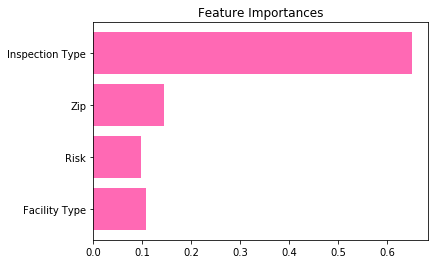

In [23]:
feature_importances = pd.Series(best_estimator.steps[1][1].feature_importances_, X_train.columns)
plt.title('Feature Importances')
plt.barh(feature_importances.index, feature_importances.values, color='hotpink');

# **Part 4: Gradient Descent**

## What does Gradient Descent seek to minimize?

Gradient Descent is one of the most popular algorithms for training ML models. Gradient Descent is an iterative method used to minimize a cost function. 

## **What is "Learning Rate" and what is its function?**

Learning rate is a hyper-parameter that controls how much we should adjust the weight of our function with in regards to the loss gradient.

